In [ ]:
import os

import numpy as np

KP_HEIGHT = 480
KP_WIDTH = 640


def load_keypoints(session_path: str, index: str) -> np.ndarray:
    # Zero pad the index: 42 -> 00042
    if len(index) < 5:
        index = "0" * (5 - len(index)) + index

    data = np.load(os.path.join(session_path, f"{index}_pose.npz"))
    return data["kp"]


def load_radar(session_path: str, index: str) -> tuple[np.ndarray, np.ndarray]:
    # Zero pad the index: 42 -> 00042
    if len(index) < 5:
        index = "0" * (5 - len(index)) + index

    data = np.load(os.path.join(session_path, f"{index}_radar.npz"))
    hm_hori = np.log(data["hm_hori"])
    hm_vert = np.log(data["hm_vert"])

    return np.asarray([hm_hori, hm_vert])


def get_keypoint_heatmaps(
    keypoints: np.ndarray,
    *,
    out_height: int = 48,
    out_width: int = 64,
    sigma: int = 2,
):
    assert keypoints.shape == (1, 17, 3)

    heatmaps = np.zeros((17, out_height, out_width), dtype=np.float32)
    for i, (x, y, conf) in enumerate(keypoints.squeeze()):
        x *= out_width / KP_WIDTH
        y *= out_height / KP_HEIGHT
        xx, yy = np.meshgrid(np.arange(out_width), np.arange(out_height))
        kp_heatmap = np.exp(-((xx - x) ** 2 + (yy - y) ** 2) / (2 * sigma**2))
        kp_heatmap[kp_heatmap < 0.01] = 0.0  # zero out tails
        heatmaps[i] = kp_heatmap

    return heatmaps


In [29]:
kp = load_keypoints("../data/raw/P1/d1s1/000", "255")
kp_heatmap = get_keypoint_heatmaps(kp)
hori, vert = load_radar("../data/raw/P1/d1s1/000", "255")
print(hori)

[[17.60585  17.833954 17.941914 ... 17.071484 16.971788 16.9156  ]
 [17.593431 17.851673 17.994104 ... 17.135141 17.015345 16.91816 ]
 [17.541193 17.827902 17.992014 ... 17.181871 17.04119  16.966255]
 ...
 [16.234259 16.221235 16.185165 ... 16.573473 16.437033 16.53122 ]
 [16.273924 16.280382 16.268244 ... 16.586824 16.468206 16.532831]
 [16.291641 16.298714 16.28895  ... 16.601912 16.488804 16.54128 ]]


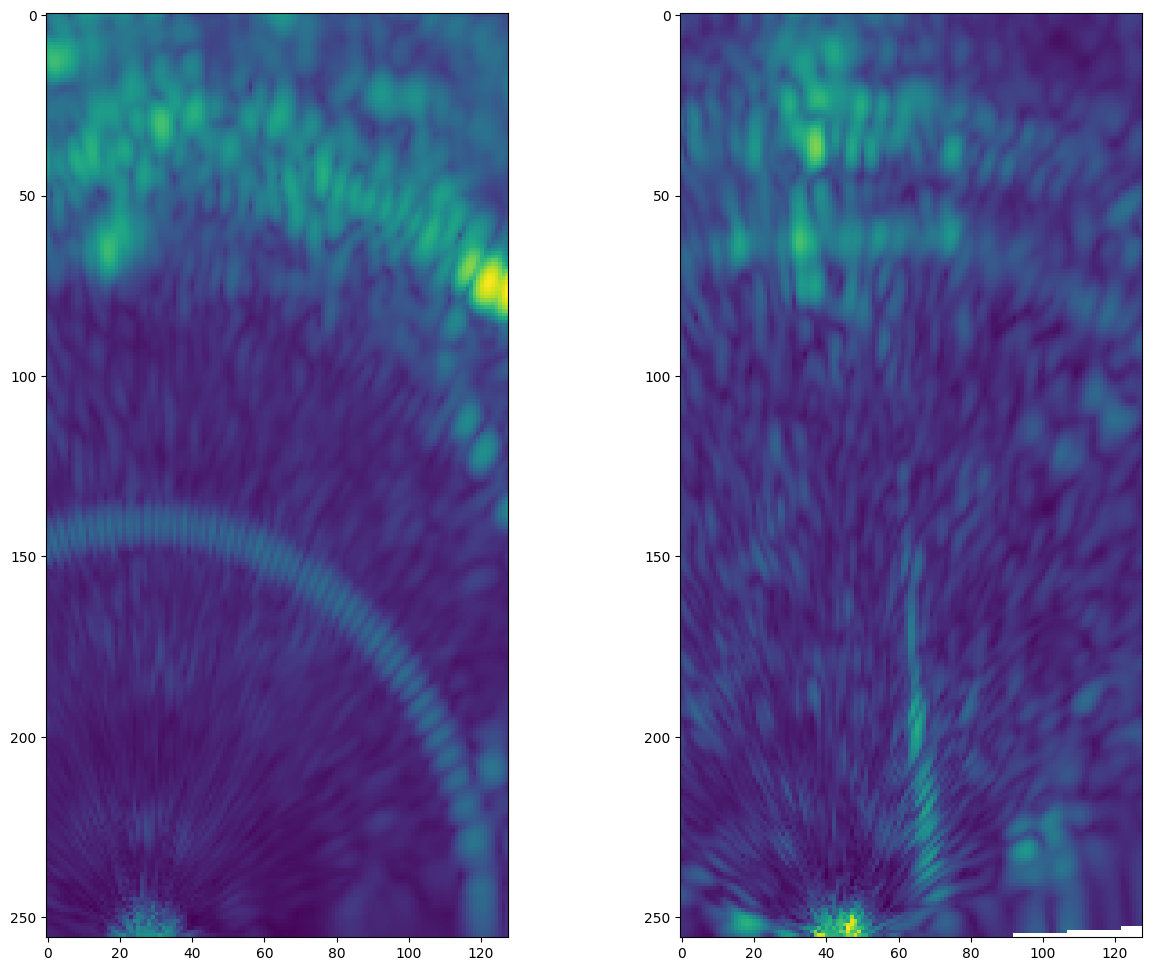

(1, 17, 3)


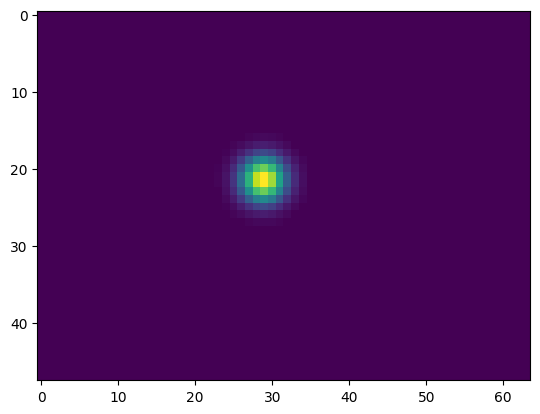

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 12))
ax= fig.add_subplot(1,2,1)
ax.imshow(hori)
ax= fig.add_subplot(1,2,2)
ax.imshow(vert)
plt.show()

print(kp.shape)
plt.imshow(kp_heatmap[0])